# LEGO Brick Recognition
Final Project: Kaan Can 090190311

## Abstract
B200C LEGO Classification Dataset: [Dataset](https://www.kaggle.com/datasets/ronanpickell/b200c-lego-classification-dataset)  (1.19GB) These images are in context, meaning objects are set in environments with random ground textures, and random lighting conditions, and each image has the potential to contain other LEGO pieces with occasional occlusion. In this project, I aim to try to obtain a model that predicts which LEGO pieces are by image processing, using this dataset that meets realistic expectations.

In [122]:
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import pandas as pd
import numpy as np

import natsort
import shutil
from random import choice

## Method
Since this is an image processing project, the [OpenCV](https://opencv.org/) library was used, and the functions of [TensorFlow](https://www.tensorflow.org/) and [Keras](https://keras.io/) libraries were used to use machine learning. And, as always, [Pandas](https://pandas.pydata.org/) and [NumPy](https://numpy.org/) libraries were used for easy manipulation of our data.

## GPU
We also use the external GPU to make machine learning processes faster. Thus, it became possible to train up to 7 times faster.

In [123]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5



## DataSet
Although things are accelerated using the GPU, it would take days to process the entire dataset, so only 5% of the dataset (10 different parts containing a total of 40,000 images) was processed to test the function.

In [124]:
ds = r"C:\Users\kaanc\OneDrive\Masaüstü\Final Project MAT381\Final Project MAT381\64"
labels = os.listdir(ds)
labels

['2450',
 '2456',
 '2540',
 '2654',
 '2877',
 '3001',
 '3002',
 '3003',
 '3004',
 '3005']

## Prepare Dataset
80% of the dataset was reserved for train and the remaining 20% for validation for use in machine learning. Created `Train` & `Test` directories for each LEGO part in the dataset.

In [125]:
def get_only_img (name: str) -> int:
    splitted = name.split(".")
    return int(splitted[0])

In [126]:
for clss in labels:
    img_path = os.path.join(ds,clss)
    imgs = natsort.natsorted(os.listdir(img_path))
    train = os.path.join(img_path, "train")
    test = os.path.join(img_path, "test")
    os.makedirs(train, exist_ok=True)
    os.makedirs(test, exist_ok=True)
    for img in imgs:
        if img.endswith(".jpg"):
            if get_only_img(img) <= 3200:
                shutil.move(os.path.join(img_path, img), os.path.join(train, img))
            else:
                shutil.move(os.path.join(img_path, img), os.path.join(test, img))

## Prepare Images
To increase the accuracy of the function, each image is made of unnecessary noise in the background, color, etc. Excessive data is extracted and image turned into a raw image consisting of only the edges of the part.

In [127]:
def get_train():
    data = []
    for label in labels:
        lbl_path = os.path.join(ds, label)
        train = os.path.join(lbl_path, "train")
        imgs = os.listdir(train)
        for img in imgs:
            img_path = os.path.join(train, img)
            img_arr = cv2.imdecode(np.fromfile(img_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
            img_arr = cv2.Canny(img_arr, threshold1=100, threshold2=200)
            img_arr = cv2.cvtColor(img_arr, cv2.COLOR_GRAY2RGB)
            data.append([img_arr, labels.index(label)])

    return data

In [128]:
def get_test():
    data = []
    for label in labels:
        lbl_path = os.path.join(ds, label)
        test = os.path.join(lbl_path, "test")
        imgs = os.listdir(test)
        for img in imgs:
            img_path = os.path.join(test, img)
            img_arr = cv2.imdecode(np.fromfile(img_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
            img_arr = cv2.Canny(img_arr, threshold1=100, threshold2=200)
            img_arr = cv2.cvtColor(img_arr, cv2.COLOR_GRAY2RGB)
            data.append([img_arr, labels.index(label)])

    return data

In [129]:
train = get_train()
val = get_test()

## Machine Learning Algorithm
The [Image Classification Model](https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/) which is mentioned by Tanishq Gautam in his article was modified to classify LEGO bricks.

In [130]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

y_train = np.array(y_train)

y_val = np.array(y_val)

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [131]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(64,64,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(len(labels)+1, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 64)        

In [132]:
opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

## Training the Model
The model was run several times (500) to increase the accuracy of training and validation and to reduce the training and validation losses. Normally, this process takes a lot of time, so only 5% of the data set was tried in terms of applicability.

In [133]:
history = model.fit(x_train,y_train,epochs = 500 , validation_data = (x_val, y_val))

Epoch 1/500


C:\Users\kaanc\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


981/981 [==============================] - 8s 8ms/step - loss: 2.3633 - accuracy: 0.1098 - val_loss: 2.3179 - val_accuracy: 0.1374
Epoch 2/500
981/981 [==============================] - 8s 8ms/step - loss: 2.3092 - accuracy: 0.1263 - val_loss: 2.2745 - val_accuracy: 0.1660
Epoch 3/500
981/981 [==============================] - 7s 7ms/step - loss: 2.2723 - accuracy: 0.1443 - val_loss: 2.2380 - val_accuracy: 0.1928
Epoch 4/500
981/981 [==============================] - 7s 7ms/step - loss: 2.2401 - accuracy: 0.1693 - val_loss: 2.2020 - val_accuracy: 0.2126
Epoch 5/500
981/981 [==============================] - 7s 7ms/step - loss: 2.2095 - accuracy: 0.1867 - val_loss: 2.1650 - val_accuracy: 0.2314
Epoch 6/500
981/981 [==============================] - 7s 7ms/step - loss: 2.1777 - accuracy: 0.2035 - val_loss: 2.1274 - val_accuracy: 0.2450
Epoch 7/500
981/981 [==============================] - 7s 7ms/step - loss: 2.1458 - accuracy: 0.2145 - val_loss: 2.0904 - val_accuracy: 0.2550
Epoch 8/500

## Visulazing the process
As can be seen in the graphs in the trained model, while the accuracy increased with each step, the loss also decreased. While it was much easier and faster to increase the efficiency in the first steps, it became more and more difficult to increase the efficiency of the result as it comes to the last steps. The results can be improved by choosing a value of more than 500 epochs, but as can be seen from the logarithmic course of the graphs, there will be no significant difference compared to the current one.

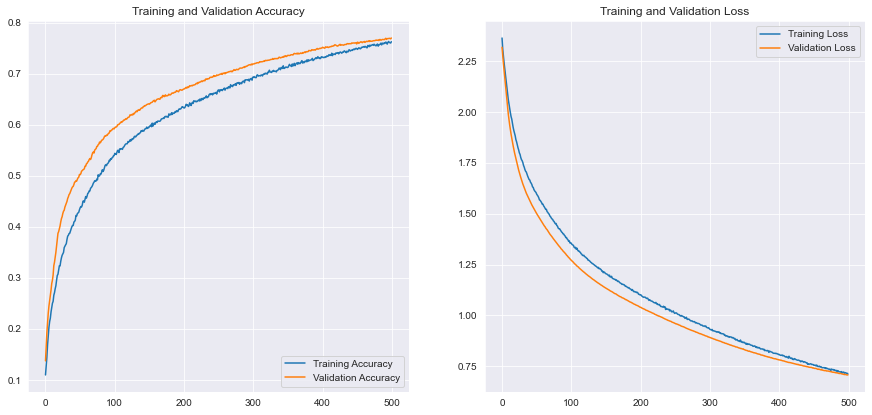

In [134]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## LEGO Catalog
In our main dataset, all LEGO pieces are named with a code. Therefore, it was aimed to find the names of the parts by extracting the [parts.csv](https://rebrickable.com/downloads/) file.

In [135]:
with open('parts.csv', encoding="utf8") as file:
    part_codes = pd.read_csv(file)
part_codes

,part_num,name,part_cat_id,part_material
0,003381,Sticker Sheet for Set 663-1,58,Plastic
1,003383,"Sticker Sheet for Sets 618-1, 628-2",58,Plastic
2,003402,"Sticker Sheet for Sets 310-3, 311-1, 312-3",58,Plastic
3,003429,Sticker Sheet for Set 1550-1,58,Plastic
4,003432,"Sticker Sheet for Sets 357-1, 355-1, 940-1",58,Plastic
...,...,...,...,...
47009,vladekmask,"Play Gear, Mask, Hard Plastic, Knights Kingdom...",17,Plastic
47010,wood03,"Storage Box, Wooden with Red Sliding Top",17,Plastic
47011,wood04,"Storage Box, Wooden with Plain Sliding Top and...",17,Plastic
47012,znapupn0001,Technic Axle Flexible 26L (Axle 2L and 5L Ends...,43,Plastic


In [136]:
other_codes = part_codes
for clss in labels:
    for row in part_codes['part_num']:
        if row == clss:
            other_codes = other_codes.drop(index=other_codes[other_codes['part_num'] == clss].index)

other_codes

,part_num,name,part_cat_id,part_material
0,003381,Sticker Sheet for Set 663-1,58,Plastic
1,003383,"Sticker Sheet for Sets 618-1, 628-2",58,Plastic
2,003402,"Sticker Sheet for Sets 310-3, 311-1, 312-3",58,Plastic
3,003429,Sticker Sheet for Set 1550-1,58,Plastic
4,003432,"Sticker Sheet for Sets 357-1, 355-1, 940-1",58,Plastic
...,...,...,...,...
47009,vladekmask,"Play Gear, Mask, Hard Plastic, Knights Kingdom...",17,Plastic
47010,wood03,"Storage Box, Wooden with Red Sliding Top",17,Plastic
47011,wood04,"Storage Box, Wooden with Plain Sliding Top and...",17,Plastic
47012,znapupn0001,Technic Axle Flexible 26L (Axle 2L and 5L Ends...,43,Plastic


In [137]:
parts_name = pd.concat([part_codes,other_codes]).drop_duplicates(keep=False)
parts_name = parts_name.sort_values(by= 'part_num')
parts_name = parts_name.reset_index(drop=True)
parts_name

,part_num,name,part_cat_id,part_material
0,2450,Wedge Plate 3 x 3 Cut Corner,49,Plastic
1,2456,Brick 2 x 6,11,Plastic
2,2540,Plate Special 1 x 2 Side Handle [Free Ends],9,Plastic
3,2654,Plate Round 2 x 2 with Rounded Bottom [Boat Stud],21,Plastic
4,2877,Brick Special 1 x 2 with Grill,5,Plastic
5,3001,Brick 2 x 4,11,Plastic
6,3002,Brick 2 x 3,11,Plastic
7,3003,Brick 2 x 2,11,Plastic
8,3004,Brick 1 x 2,11,Plastic
9,3005,Brick 1 x 1,11,Plastic


In [138]:
names = list(parts_name['name'])
names

['Wedge Plate 3 x 3 Cut Corner',
 'Brick 2 x 6',
 'Plate Special 1 x 2 Side Handle [Free Ends]',
 'Plate Round 2 x 2 with Rounded Bottom [Boat Stud]',
 'Brick Special 1 x 2 with Grill',
 'Brick 2 x 4',
 'Brick 2 x 3',
 'Brick 2 x 2',
 'Brick 1 x 2',
 'Brick 1 x 1']

## Results
As a result, the predictive success of our model is listed below for each part separately. On average, it was concluded that our model made predictions with an accuracy rate of 78%.

Here I think the `Wedge Plate 3 x 3 Cut Corner` piece has the highest prediction success of 92% because it has a very different shape from the other pieces. On the contrary, the acuracy estimate may be low, as `Brick 1 x 2` has a very similar example as `Brick Special 1 x 2 with Grill` piece of brick".

In [139]:
predictions = np.argmax(model.predict(x_val),axis=1)
print(classification_report(y_val, predictions, target_names = names))

250/250 [==============================] - 1s 3ms/step
                                                   precision    recall  f1-score   support

                     Wedge Plate 3 x 3 Cut Corner       0.92      0.93      0.92       800
                                      Brick 2 x 6       0.82      0.87      0.84       800
      Plate Special 1 x 2 Side Handle [Free Ends]       0.79      0.87      0.83       800
Plate Round 2 x 2 with Rounded Bottom [Boat Stud]       0.90      0.89      0.89       800
                   Brick Special 1 x 2 with Grill       0.87      0.58      0.70       800
                                      Brick 2 x 4       0.75      0.66      0.70       800
                                      Brick 2 x 3       0.72      0.66      0.69       800
                                      Brick 2 x 2       0.81      0.69      0.74       800
                                      Brick 1 x 2       0.53      0.76      0.63       800
                                  

## Let's test the model ourselves
First of all, the image we want to test is converted into a format similar to the data we train. Then we can see how the model predicts for this image.

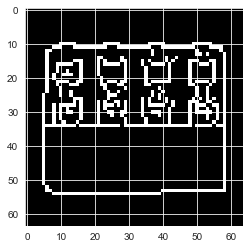

In [140]:
path = r'C:\Users\kaanc\OneDrive\Masaüstü\Final Project MAT381\Final Project MAT381\test2.jpg'
arr = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
arr = cv2.resize(arr, (64, 64), interpolation= cv2.INTER_LINEAR)
arr = cv2.Canny(arr, threshold1=100, threshold2=200)
arr = cv2.cvtColor(arr, cv2.COLOR_GRAY2RGB)
plt.imshow(arr)

In [141]:
pred = model.predict(tf.reshape(arr, [-1, 64, 64, 3]))

1/1 [==============================] - 0s 72ms/step


In [142]:
pred[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [143]:
pairs = []
for i in range(len(pred[0])):
    pairs.append([i, pred[0][i]])

pairs = sorted(pairs, key=lambda a: a[1], reverse=True)
pairs

[[1, 1.0],
 [0, 0.0],
 [2, 0.0],
 [3, 0.0],
 [4, 0.0],
 [5, 0.0],
 [6, 0.0],
 [7, 0.0],
 [8, 0.0],
 [9, 0.0],
 [10, 0.0]]

In [188]:
print(f'The tested image is predicted to be "{names[pairs[0][0]]}" Precision: {int(pairs[0][1]*100)}%')

The tested image is predicted to be "Brick 2 x 4" Precision: 100%


The model actually made an accurate prediction for this example

Let's see how the model predicts 10 of the testable images

In [184]:
random_test_imgs = []
test_container = r'C:\Users\kaanc\OneDrive\Masaüstü\Final Project MAT381\Final Project MAT381\Test Container'
test_imgs = os.listdir(test_container)
for img in test_imgs:
    rnd_img = choice(test_imgs)
    if not rnd_img in random_test_imgs:
        random_test_imgs.append(rnd_img)
    if len(random_test_imgs) == 10:
        break

random_test_imgs = [os.path.join(test_container, imgi) for imgi in random_test_imgs]
print(random_test_imgs)

['C:\\Users\\kaanc\\OneDrive\\Masaüstü\\Final Project MAT381\\Final Project MAT381\\Test Container\\10.jpg', 'C:\\Users\\kaanc\\OneDrive\\Masaüstü\\Final Project MAT381\\Final Project MAT381\\Test Container\\27.jpg', 'C:\\Users\\kaanc\\OneDrive\\Masaüstü\\Final Project MAT381\\Final Project MAT381\\Test Container\\4.jpg', 'C:\\Users\\kaanc\\OneDrive\\Masaüstü\\Final Project MAT381\\Final Project MAT381\\Test Container\\17.jpg', 'C:\\Users\\kaanc\\OneDrive\\Masaüstü\\Final Project MAT381\\Final Project MAT381\\Test Container\\8.jpg', 'C:\\Users\\kaanc\\OneDrive\\Masaüstü\\Final Project MAT381\\Final Project MAT381\\Test Container\\22.jpg', 'C:\\Users\\kaanc\\OneDrive\\Masaüstü\\Final Project MAT381\\Final Project MAT381\\Test Container\\23.jpg', 'C:\\Users\\kaanc\\OneDrive\\Masaüstü\\Final Project MAT381\\Final Project MAT381\\Test Container\\25.jpg', 'C:\\Users\\kaanc\\OneDrive\\Masaüstü\\Final Project MAT381\\Final Project MAT381\\Test Container\\11.jpg', 'C:\\Users\\kaanc\\OneDrive\\

In [185]:
originals = []
edges = []
for img in random_test_imgs:
    arr = cv2.imdecode(np.fromfile(img, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    originals.append(arr)
    arr = cv2.resize(arr, (64, 64), interpolation= cv2.INTER_LINEAR)
    arr = cv2.Canny(arr, threshold1=100, threshold2=200)
    arr = cv2.cvtColor(arr, cv2.COLOR_GRAY2RGB)
    edges.append(arr)

In [186]:
msgs = []
for edge_img in edges:
    pred = model.predict(tf.reshape(edge_img, [-1, 64, 64, 3]))
    pairs = []
    for i in range(len(pred[0])):
        pairs.append([i, pred[0][i]])

    pairs = sorted(pairs, key=lambda a: a[1], reverse=True)
    msgs.append(f'The tested image is predicted to be "{names[pairs[0][0]]}" Precision: {int(pairs[0][1]*100)}%')

1/1 [==============================] - 0s 18ms/step


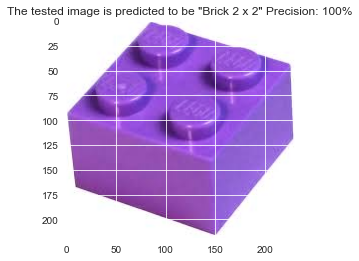

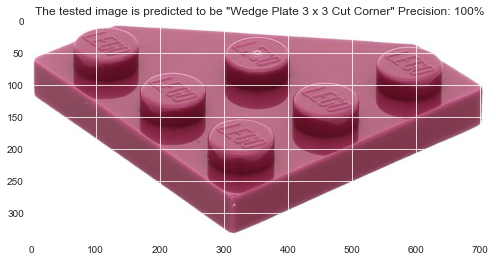

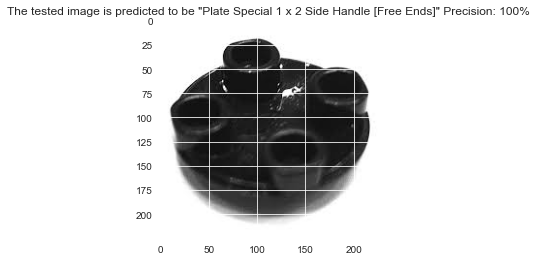

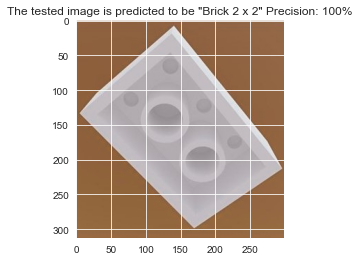

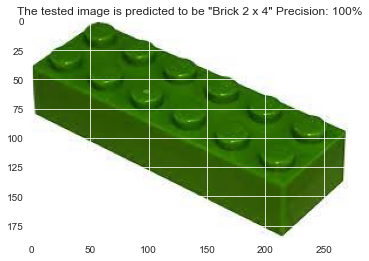

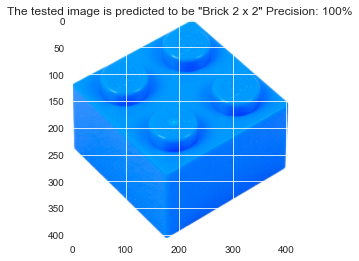

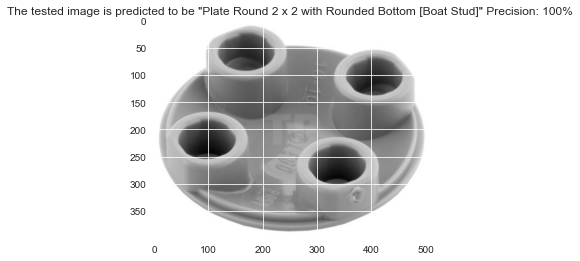

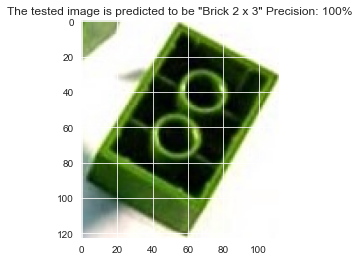

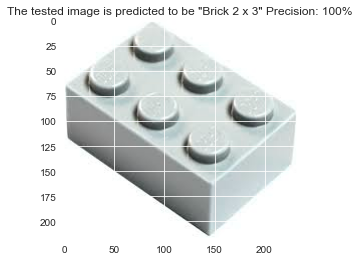

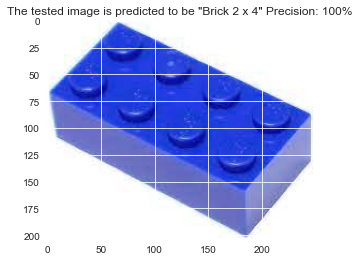

In [187]:
for i in range(len(originals)):
    fig = plt.figure(figsize=(20,4))
    ax1 = fig.add_subplot()
    ax1.imshow(originals[i])
    ax1.title.set_text(msgs[i])

In this experiment, the model accurately predicted 8 out of 10 images. The result is quite similar to the 78% validation margin the computer got from the 8,000 images used for testing.

## References
[1]. Gautam, T. (October, 2020), [Create your Own Image Classification Model using Python and Keras](https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/), web

[2]. LearnOpenCV Team (Org.). (June, 2012), [Edge Detection Using OpenCV](https://learnopencv.com/edge-detection-using-opencv/), web

[3]. Sentdex. (August, 2018), [Loading in your own data - Deep Learning basics with Python, TensorFlow and Keras](https://pythonprogramming.net/loading-custom-data-deep-learning-python-tensorflow-keras/), web

DataSets:

[4]. Pickel, R. (July, 2021), [B200C LEGO Classification Dataset](https://www.kaggle.com/datasets/ronanpickell/b200c-lego-classification-dataset)

[5]. Rebrickable. (May, 2022), [parts.csv](https://rebrickable.com/downloads/)